In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error


In [2]:
# Load the datasets
bank = pd.read_csv('bancos_python.csv')
rubrica = pd.read_csv('rubricas_python.csv', index_col=[0]).T.to_dict(orient='records') # Transpose the rubricas dataset and convert it to a dictionary
                                                                                        # To work with it as a pivot table later

# Preprocess the Data

In [3]:
# Parse dates and set the col 'Data' as index
bank['Data'] = pd.to_datetime(bank['Data'], format='%d/%m/%Y')
bank.set_index('Data', inplace=True)
bank.index

DatetimeIndex(['2022-01-01', '2022-01-01', '2022-01-01', '2021-01-01',
               '2022-01-01', '2022-01-01', '2022-01-01', '2022-01-01',
               '2022-01-01', '2022-01-02',
               ...
               '2021-05-31', '2021-05-31', '2021-04-30', '2021-04-30',
               '2021-03-31', '2021-03-31', '2021-02-26', '2021-02-26',
               '2021-01-29', '2021-01-29'],
              dtype='datetime64[ns]', name='Data', length=28863, freq=None)

In [4]:
# Clean the bank dataset, keeping only the columns 'Valor' and 'BNCDoc'
bank = bank[['Valor', 'BNCDoc']]

# The rubrica dict is a pivot table, matching the bank dataset' 'BNCDoc' with the supposed rubricas
# We will create a new 'Rubrica' column, matching the rubricas dict with the bank dataset
# Also, if the value for the BNCDoc is 'abertura' it should map to 'Abertura'
bank['Rubrica'] = bank['BNCDoc'].map(rubrica[0])
bank.loc[bank['BNCDoc'] == 'abertura', 'Rubrica'] = 'Abertura'

# Let's remove the 'BNCDoc' column as we don't need it anymore
bank.drop('BNCDoc', axis=1, inplace=True)

# Remove the symbol from the 'Valor' column and convert it to float
bank['Valor'] = bank['Valor'].str.split(' ').str[0].str.replace(',', '').astype(float)

# We can remove the 'Rubrica' rows with Transferencias_internas, as they are not relevant for the analysis
bank = bank[bank['Rubrica'] != 'Transferencias_internas']

In [5]:
# Make and clean a pivot table
# Since Rubrica is a categorical variable, we should assign each value the corresponding value from 'Valor'
# We can do this by creating a pivot table with the 'Rubrica' values as columns and the 'Valor' as values
def pivot_table(df):

    pivot = df.pivot_table(index='Data', columns='Rubrica', values='Valor', aggfunc='sum')
    
    return pd.concat([df, pivot], axis=1).drop(['Rubrica', 'Valor'], axis=1) # The new columns should be added back to the bank dataset

bank = pivot_table(bank)

array([[<Axes: xlabel='Data'>, <Axes: xlabel='Data'>,
        <Axes: xlabel='Data'>],
       [<Axes: xlabel='Data'>, <Axes: xlabel='Data'>,
        <Axes: xlabel='Data'>],
       [<Axes: xlabel='Data'>, <Axes: xlabel='Data'>,
        <Axes: xlabel='Data'>]], dtype=object)

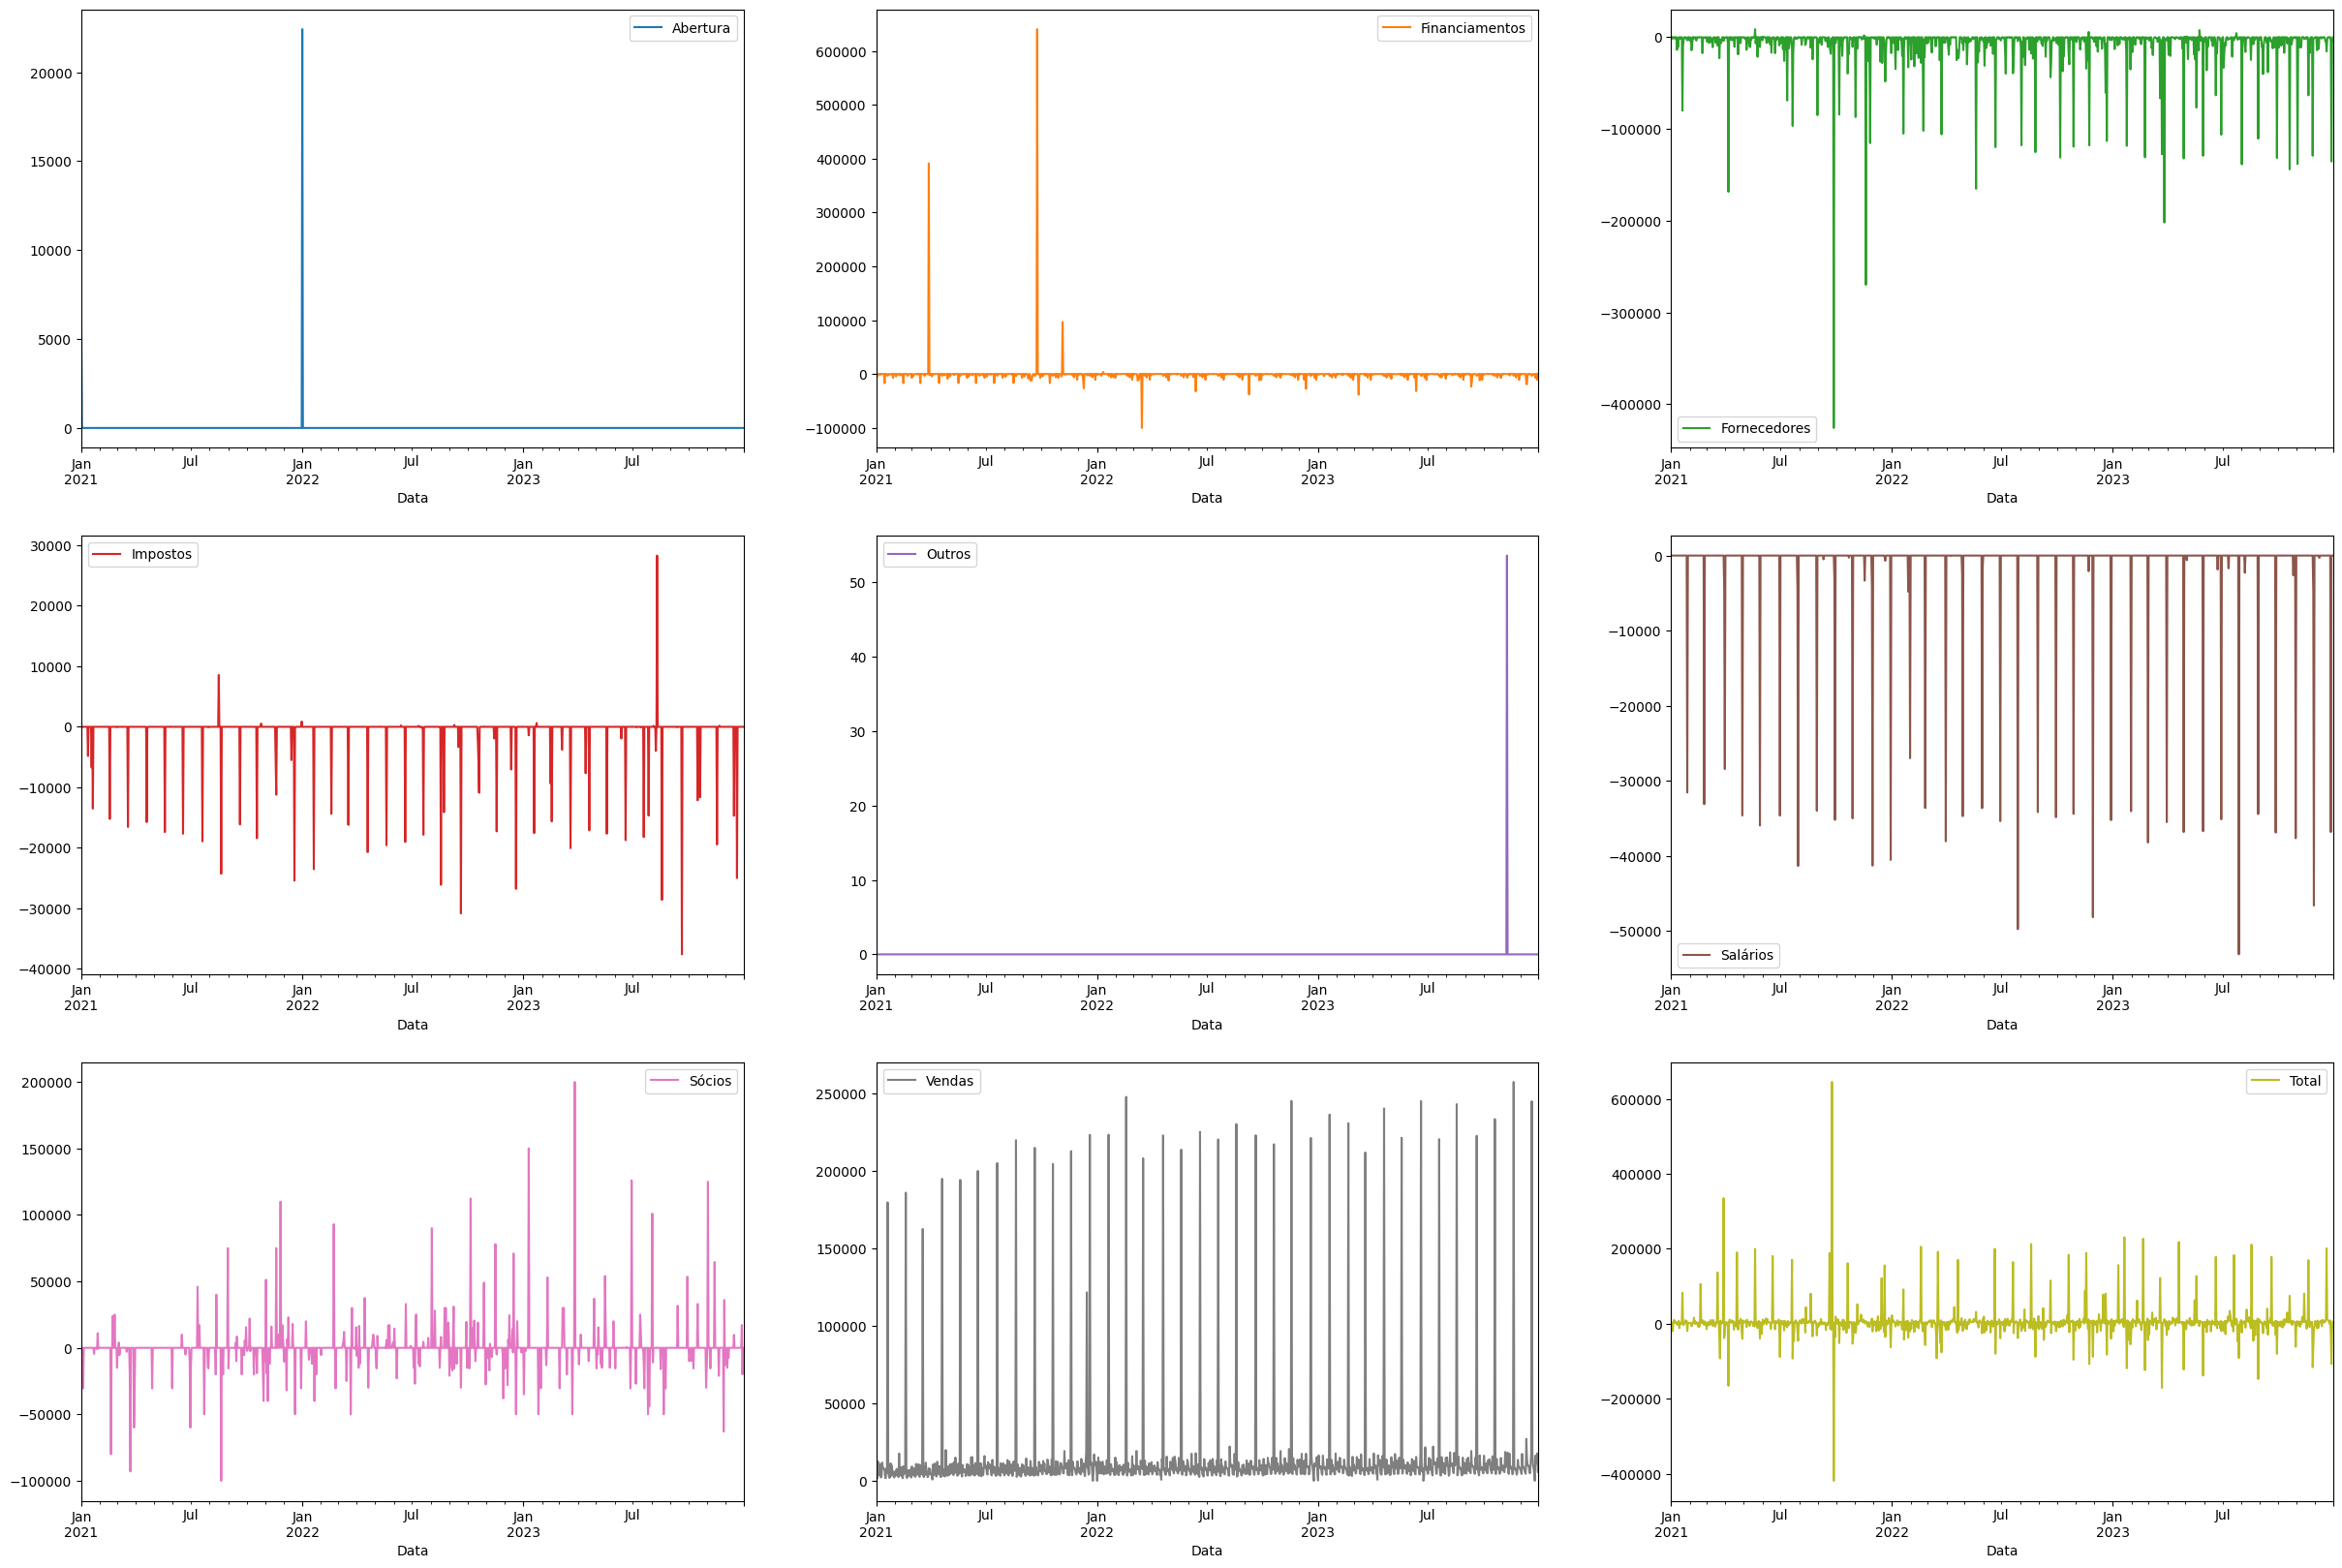

In [6]:
# Resample the dataset to a daily frequency, filling the missing values with 0
bank = bank.resample(rule='D').max().fillna(0) # This is done since our TARGET is the daily total

# Add a Total column to sum the total for the day
bank['Total'] = bank.sum(axis=1)

# Let's plot the dataset as a line plot to see the evolution of the values daily
bank.plot(kind='line', subplots=True, layout=(3, 3), sharex=False, sharey=False, legend=True, figsize=(30, 20))

In [7]:
# Plot functions

def plot_predictions(y_test, preds, TARGET):
    """
    Plot the predictions for each column in the TARGET.
    """
    fig, ax = plt.subplots(4, 2, figsize=(20, 20), sharex=True)

    for i, col in enumerate(TARGET):
        y_test[col].plot(ax=ax[i//2, i%2], title=col)
        preds[col + '_pred'].plot(ax=ax[i//2, i%2], title=col)
        # Separate the train and test datasets with a vertical line
        ax[i//2, i%2].axvline(y_test.index[0], color='r', linestyle='--')
        # Add a legend
        ax[i//2, i%2].legend(['True', 'Predicted'])
        
    # Remove the X axis label for the subplots
    for i in range(4):
        for j in range(2):
            ax[i, j].set_xlabel('')
            
    return plt.show()

def plot_train_test(train, test, TARGET):
    # Let's plot the train and test datasets for our TARGET
    # Plot it in different subplots in the same figure
    # Use a 4x2 layout

    fig, ax = plt.subplots(4, 2, figsize=(20, 20))

    for i, col in enumerate(TARGET):
        train[col].plot(ax=ax[i//2, i%2], title=col)
        test[col].plot(ax=ax[i//2, i%2], title=col)
        # Separate the train and test datasets with a vertical line
        ax[i//2, i%2].axvline(train.index[-1], color='r', linestyle='--')
    
    return plt.show()

In [8]:
# Make a Function that takes the dataset, the model and the target, the features and returns the predictions
# It should resample the dataset to a chosen frequency, filling the missing values with 0

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

def create_lagged_features(df, target_col, lag_values):
    """
    Create lagged features for the target variable and concatenate them with the original dataset.
    """
    df = df.copy()
    for lag in lag_values:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

def split_dataset(df, horizon, FEATURES, TARGET, graph_sets = False):
    """
    Split the dataset into train and test using the horizon.
    """
    # Split the dataset into train and test using the horizon
    train = df[:-horizon]
    test = df.tail(horizon)
        
    # Define X_train, y_train, X_test, y_test
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
        
    if graph_sets:
        plot_train_test(train, test, TARGET)
    
    return X_train, y_train, X_test, y_test


def forecast_liquidity(df, model, horizon, TARGET, FEATURES, imp_features = False, graph_sets = False, graph_predictions = False):
    
    df = create_features(df) # Create the features in the dataset

    X_train, y_train, X_test, y_test = split_dataset(df, horizon, FEATURES, TARGET, graph_sets) # Split the dataset into train and test
        
    # Fit the model 
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
        
    # Make predictions
    # Turn the predictions into a DataFrame
    # Name the columns with the _pred suffix

    preds = pd.DataFrame(model.predict(X_test), index=y_test.index, columns=[col + '_pred' for col in TARGET])
        
    # Print the RMSE for each column
    for col in TARGET:
        print(f'RMSE for {col}: {root_mean_squared_error(y_test[col], preds[col + "_pred"])}')
        
    if imp_features:
        # Graph Feature Importance to see which features are affecting the model the most
        fi = pd.DataFrame(data=model.feature_importances_,
                        index=model.feature_names_in_,
                        columns=['importance'])
        fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
        plt.show()
        
    if graph_predictions:
        plot_predictions(y_test, preds, TARGET)
                
    return preds

In [9]:
bank = create_lagged_features(bank, 'Vendas', [20]) #Finfarma payments on the 20th
bank = create_lagged_features(bank, 'Impostos', [19]) #Taxes on the 19th
bank = create_lagged_features(bank, 'Salários', [27]) #Salaries on the 27th
bank.fillna(0, inplace=True) # Fill the missing values with 0

In [10]:
horizon = 30
FEATURES = [
    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'Vendas_lag20', 'Impostos_lag19', 'Salários_lag27'
]

lags = [
    'Vendas_lag20', 'Impostos_lag19', 'Salários_lag27'
]

TARGET = bank.drop(lags, axis=1).columns.difference(['Total']) # The TARGET is the columns in the bank dataset that are not 'Total' or the FEATURES

# Use GridsearchCV to get the best hyperparameters for our model

In [18]:
# Let's improve our model using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Create a parameter grid with the parameters we want to tune

param_grid = {
    'n_estimators': [50, 100, 250, 500, 1000, 2000],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

regressor = xgb.XGBRegressor()

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    estimator=regressor, 
    param_grid=param_grid, 
    scoring='neg_root_mean_squared_error',
)


In [19]:
# Prepare the dataset
bank = create_features(bank)
X_train, y_train, X_test, y_test = split_dataset(bank, horizon, FEATURES, TARGET, graph_sets=False)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}


# Run the model with the best parameters

[0]	validation_0-rmse:20387.19317	validation_1-rmse:18935.03278


c:\Users\jprib\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12566.80358	validation_1-rmse:12001.20215
[200]	validation_0-rmse:9924.05482	validation_1-rmse:10513.76935
[249]	validation_0-rmse:9297.03541	validation_1-rmse:10361.02022
RMSE for Abertura: 48.143714904785156
RMSE for Financiamentos: 4194.375292327422
RMSE for Fornecedores: 23347.034702309058
RMSE for Impostos: 4114.436039185025
RMSE for Outros: 48.189239501953125
RMSE for Salários: 8200.8454784154
RMSE for Sócios: 10678.144213094072
RMSE for Vendas: 9874.525304928213


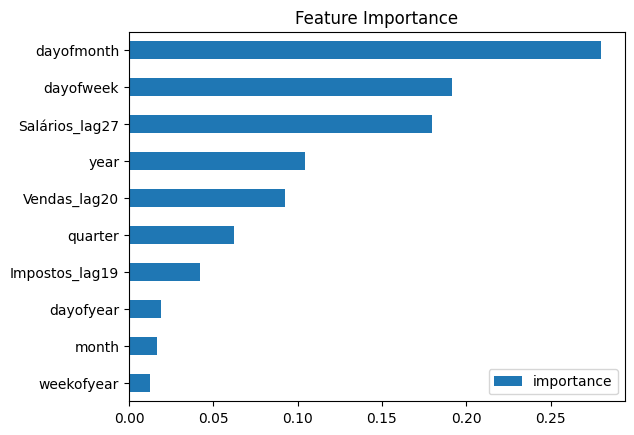

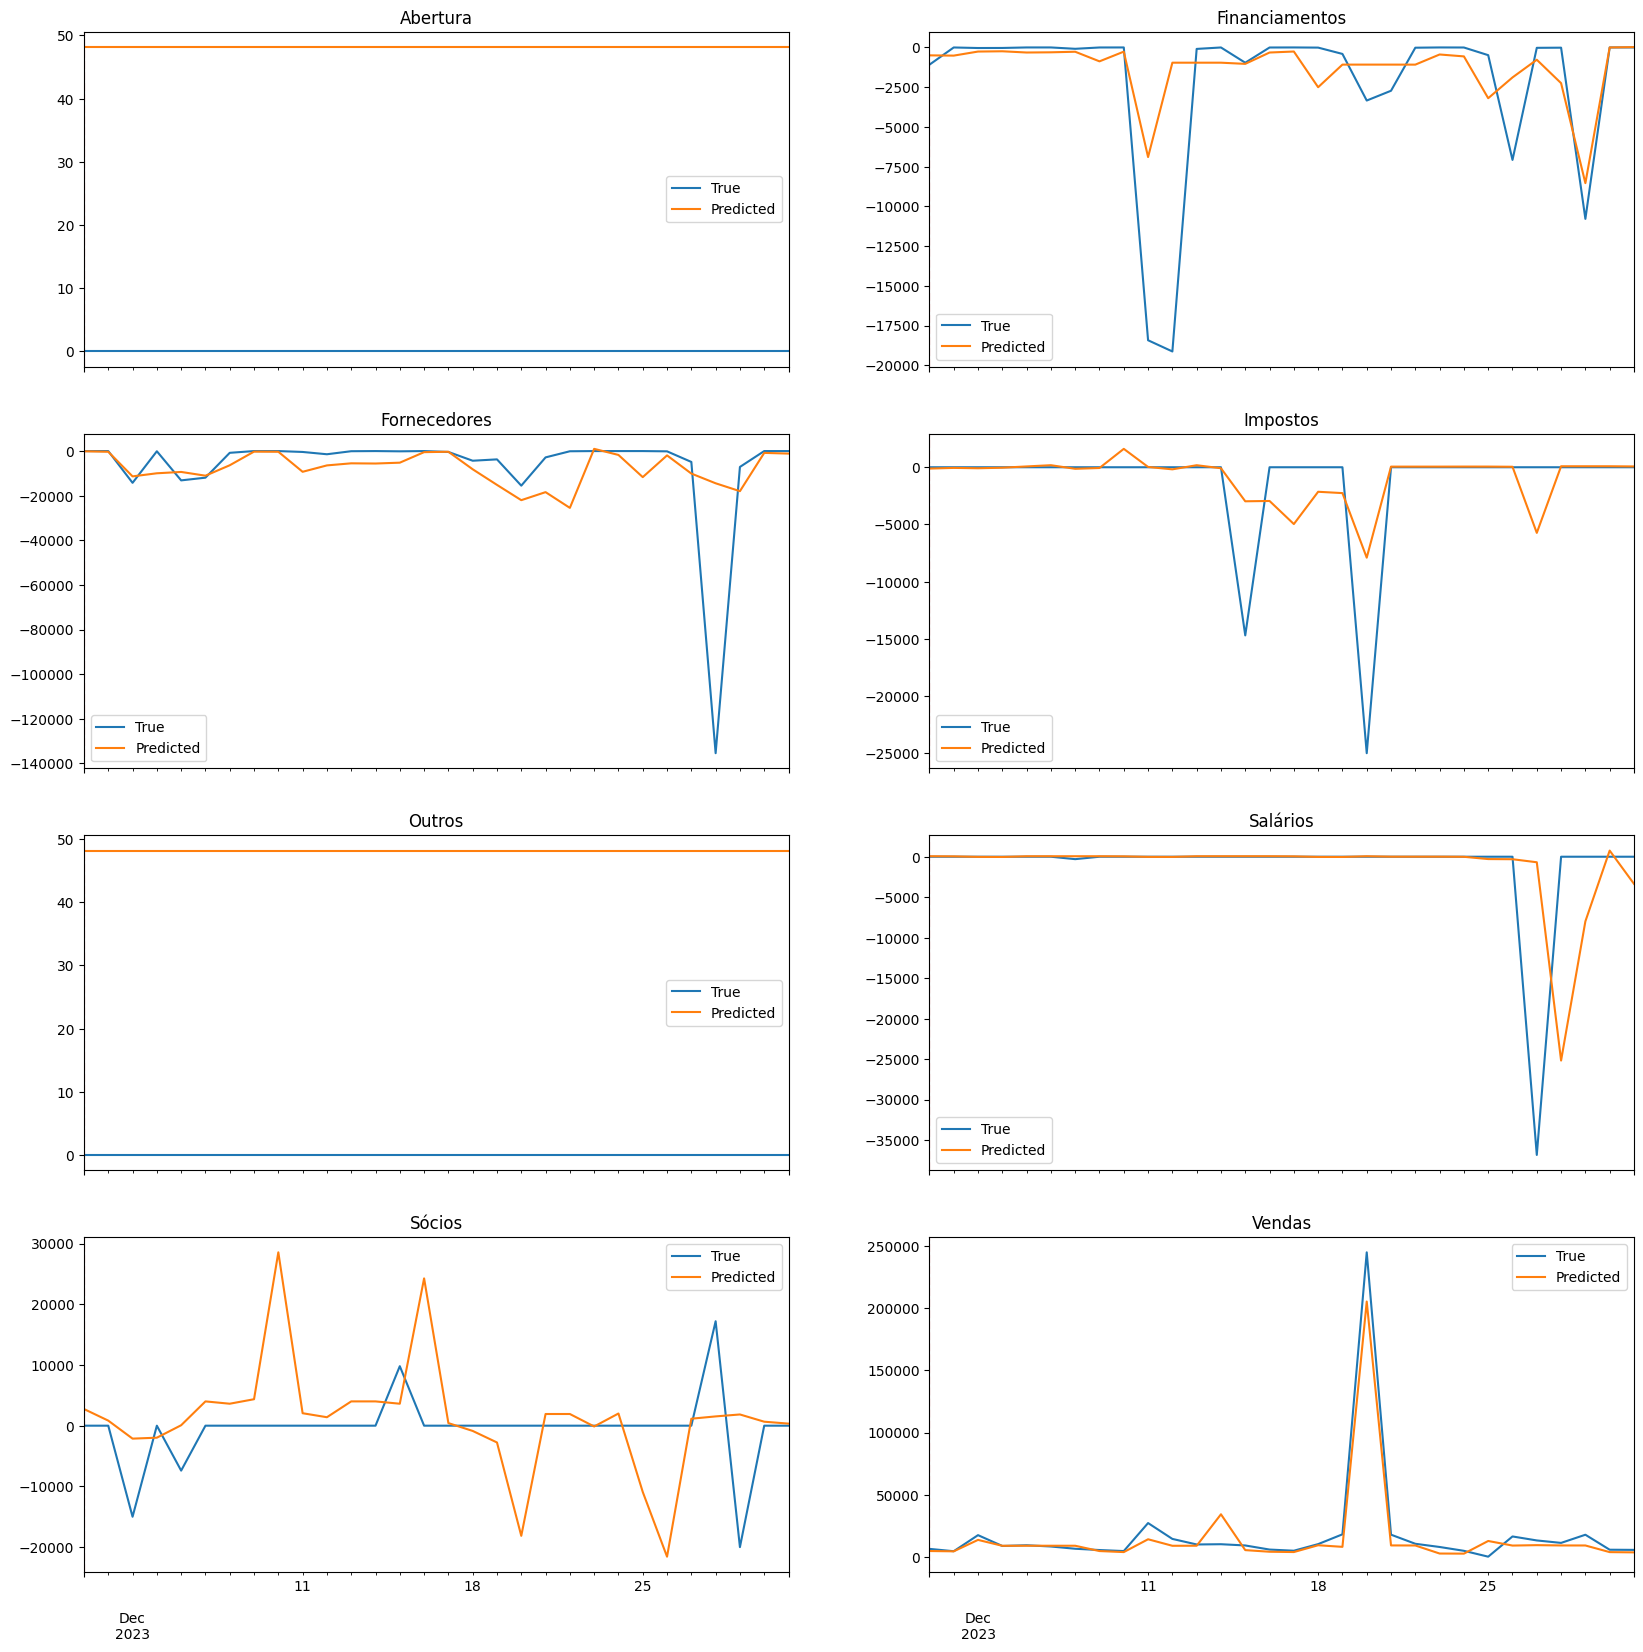

In [20]:
# Run the model with the best parameters
reg = xgb.XGBRegressor(booster='gbtree',    
                        n_estimators=250,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=5,
                        learning_rate=0.01)

preds = forecast_liquidity(bank, reg, horizon, TARGET, FEATURES, imp_features=True, graph_sets=False, graph_predictions=True)

# Make predictions for the near future

In [10]:
# Let's make some predictions on the near future

horizon = 30
FEATURES = [
    'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'Vendas_lag20', 'Impostos_lag19', 'Salários_lag27'
]

lags = [
    'Vendas_lag20', 'Impostos_lag19', 'Salários_lag27'
]

TARGET = bank.drop(lags, axis=1).columns.difference(['Total']) # The TARGET is the columns in the bank dataset that are not 'Total'
TARGET = TARGET.difference(FEATURES)                           # or the FEATURES

# First, we need to train the model with the whole data

df = create_features(bank)
horizon = 90

X_all = df[FEATURES]
y_all = df[TARGET]

model = xgb.XGBRegressor(booster='gbtree',    
                        n_estimators=250,
                        early_stopping_rounds=50,
                        objective='reg:linear',
                        max_depth=5,
                        learning_rate=0.01)

model.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=False)

c:\Users\jprib\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=250, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [12]:
# Create a feature dataframe
last_date = df.index[-1]
forecast_time = pd.date_range(start=last_date, 
              periods=horizon+1, 
              freq='D')

forecast_df = pd.DataFrame(index=forecast_time)
forecast_df['isFuture'] = True
bank['isFuture'] = False
df_and_future = pd.concat([bank, forecast_df])
df_and_future = create_features(df_and_future)
df_and_future = create_lagged_features(df_and_future, 'Vendas', [20])
df_and_future = create_lagged_features(df_and_future, 'Impostos', [19])
df_and_future = create_lagged_features(df_and_future, 'Salários', [27])
df_and_future.fillna(0, inplace=True)

In [13]:
# Keep the last month of data that we have available
# By setting the isFuture column to True for that month and year
# We will use this data to make the predictions
df_and_future.loc[(df_and_future.index.month == last_date.month) & (df_and_future.index.year == last_date.year), 'isFuture'] = True
forecast_df_with_feat = df_and_future.query('isFuture').copy()
forecast_df_with_feat = forecast_df_with_feat.drop('isFuture', axis=1)

In [15]:
preds = pd.DataFrame(model.predict(forecast_df_with_feat[FEATURES]), index=forecast_df_with_feat.index, columns=[col + '_pred' for col in TARGET])

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

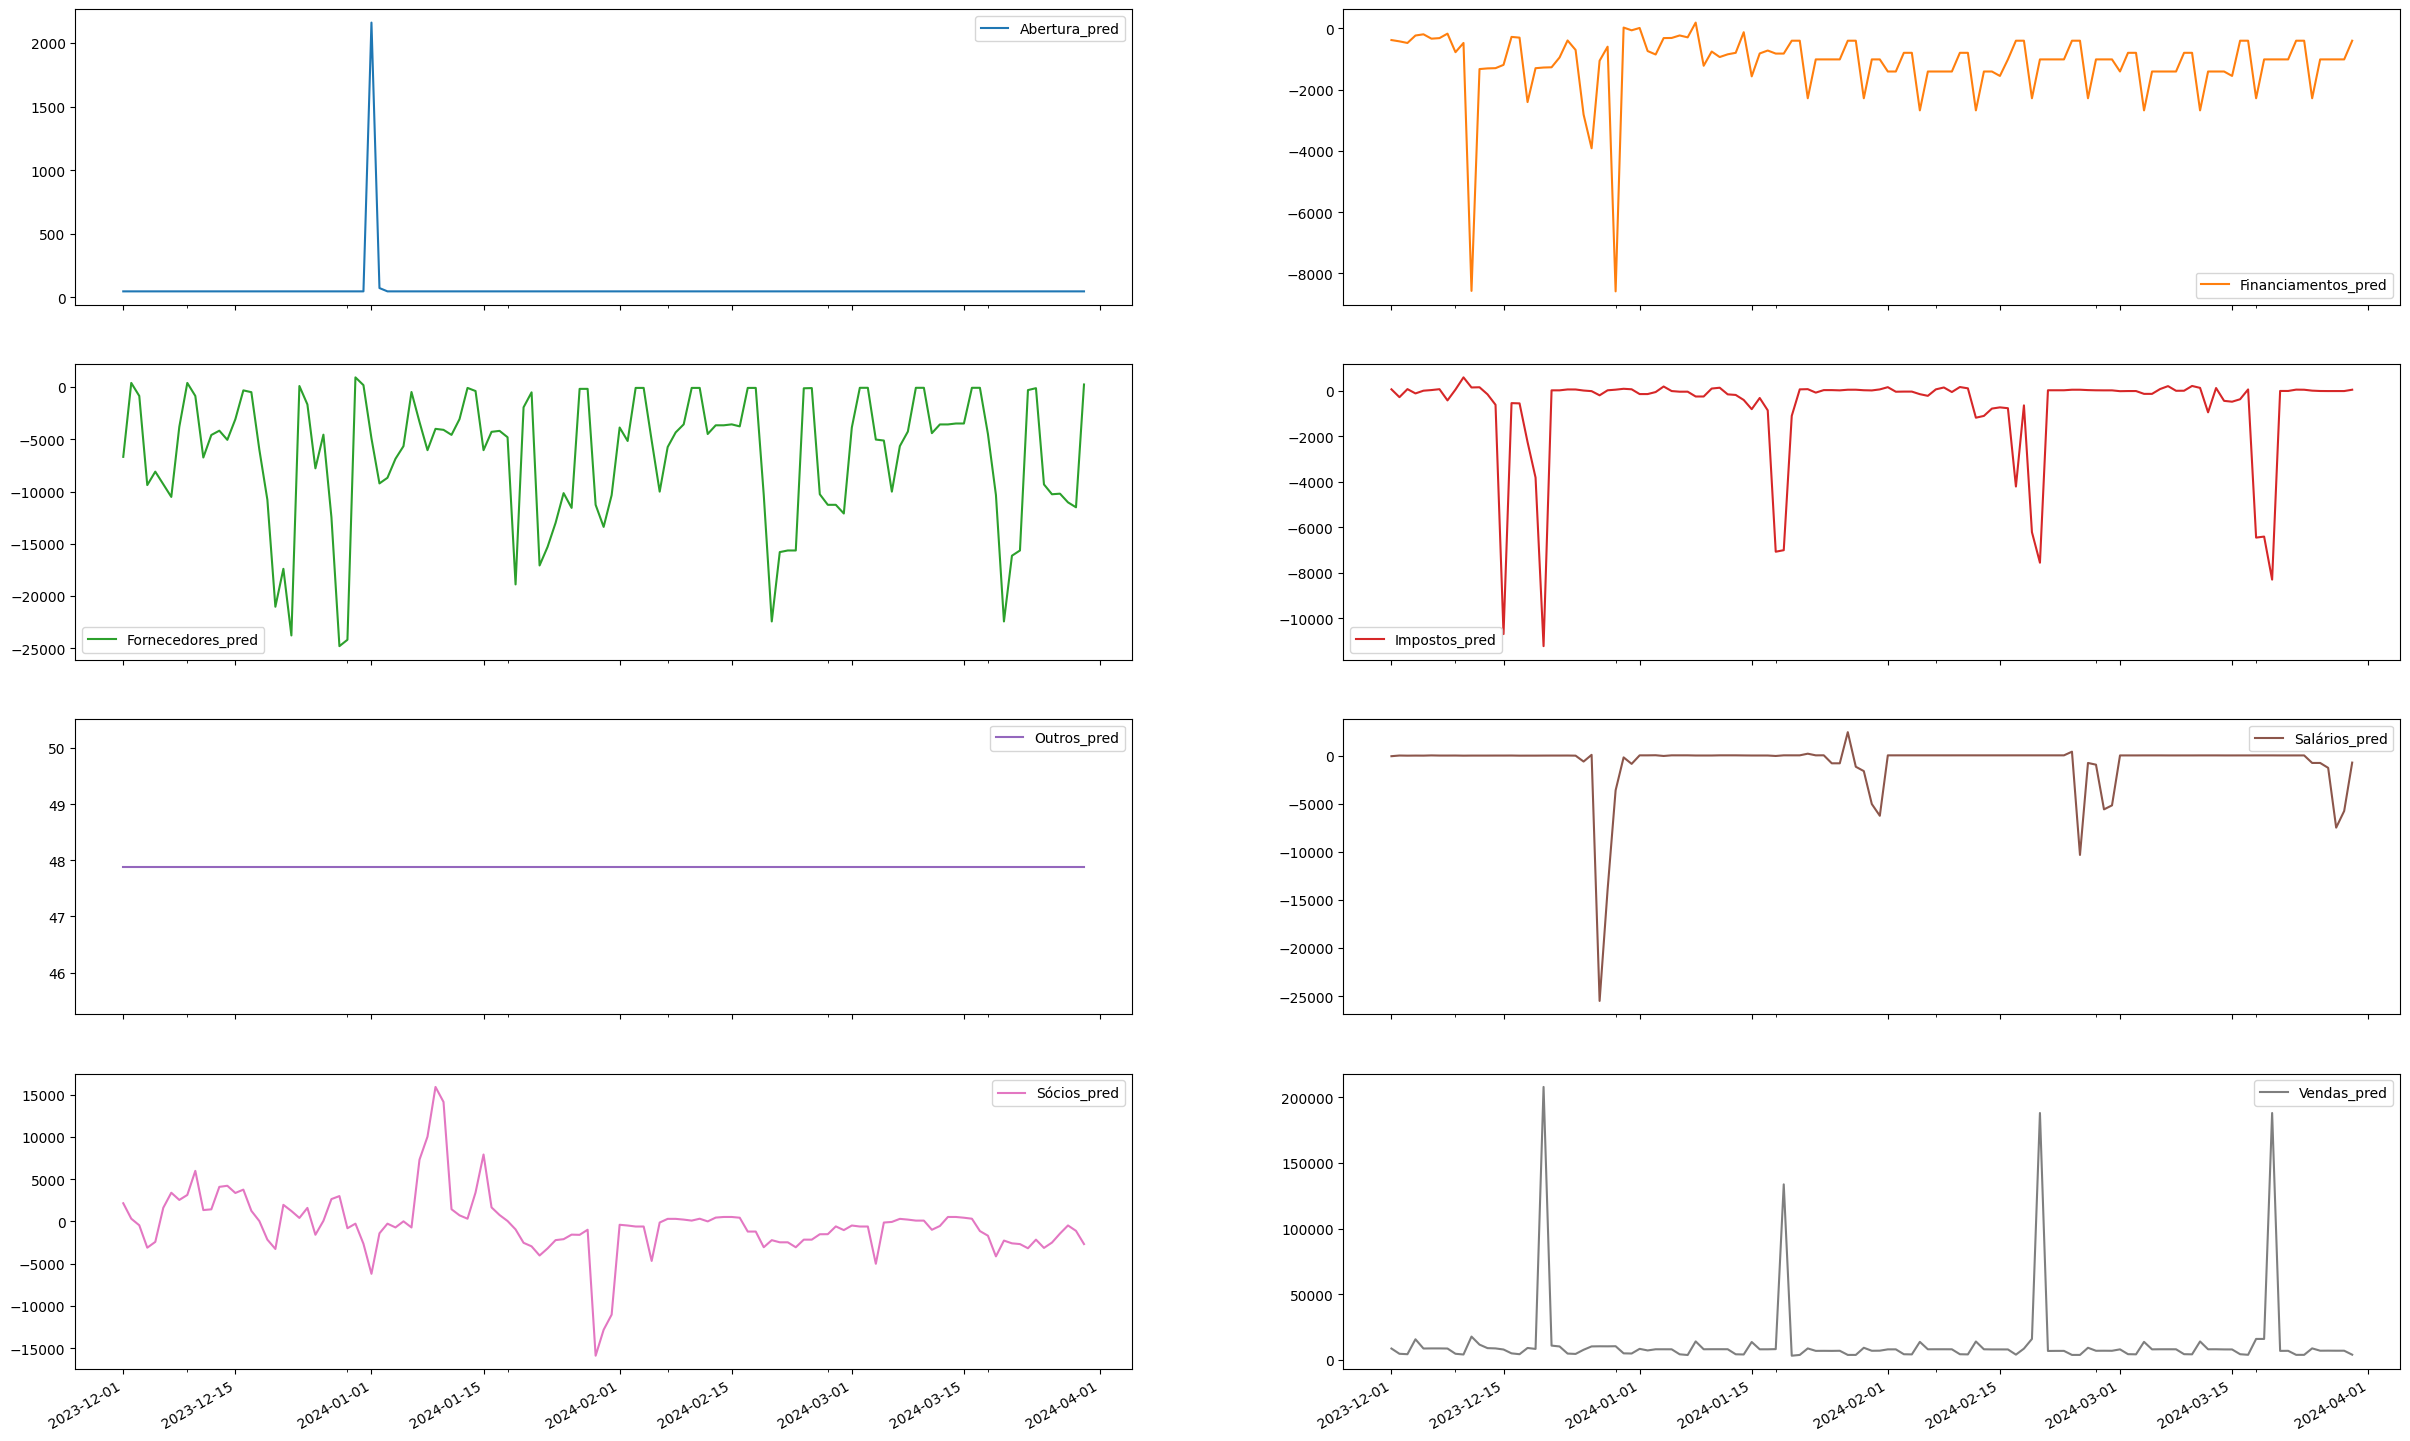

In [16]:
preds.plot(kind='line', subplots=True, layout=(4, 2), sharex=True, sharey=False, legend=True, figsize=(30, 20))

In [ ]:
# Save model
reg.save_model('BankLiquidityForecaster.json')